# **Import Libraries**

In [67]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import spacy
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **Load Dataset**

In [ ]:
data=pd.read_csv('/content/Language Detection.csv', engine='python')
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [ ]:
data.shape

(10436, 2)

In [ ]:
data.describe(include='O').transpose()

,count,unique,top,freq
Text,10436,10366,Mi dispiace.,3
Language,10436,18,English,1385


# **Data Cleaning**

In [ ]:
data.fillna("", inplace=True)
data.isna().sum()

Text        0
Language    0
dtype: int64

In [ ]:
data['Language'].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           94
Bengali         68
Name: Language, dtype: int64

# **Visualization**

Text(0.5, 1.0, 'Target Labels')

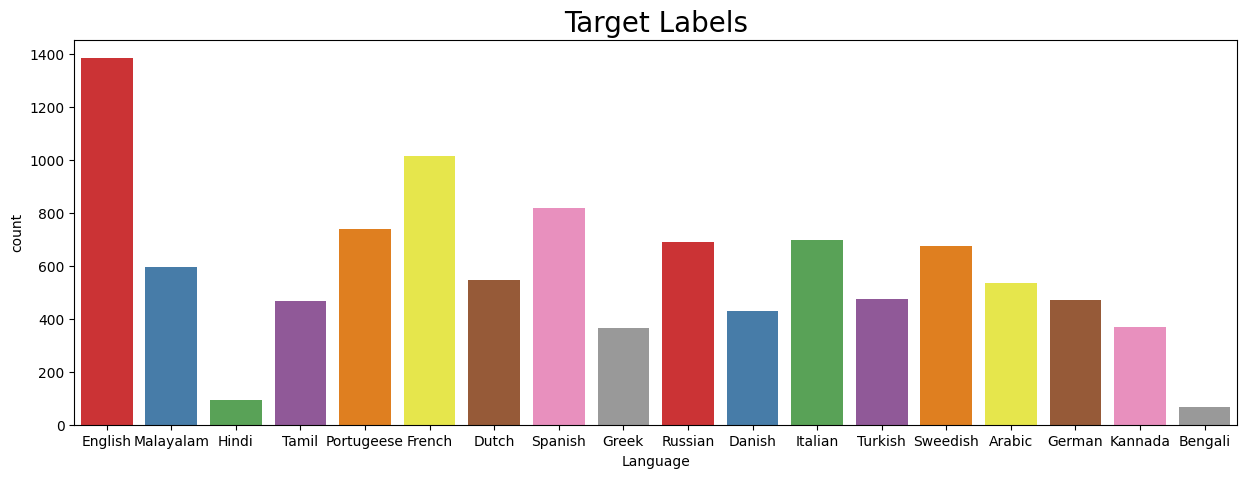

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x='Language',data=data,palette='Set1')
plt.title('Target Labels',fontsize=20)

<function matplotlib.pyplot.show(close=None, block=None)>

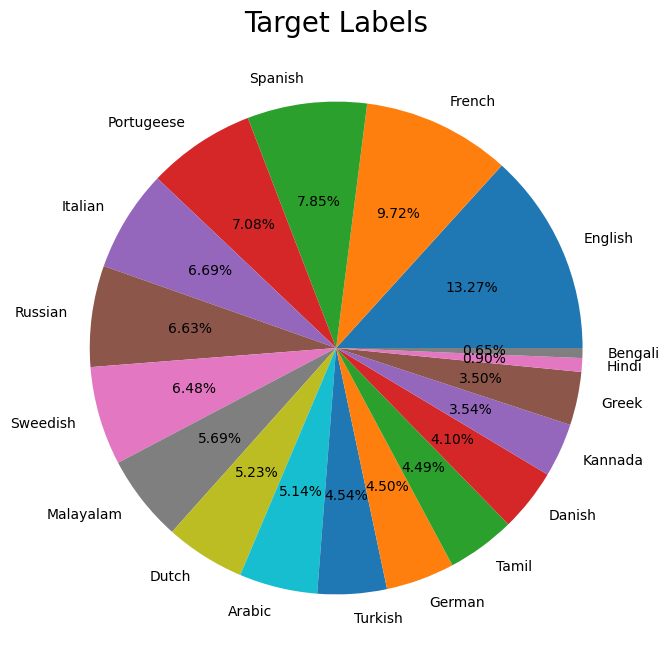

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(x = data['Language'].value_counts() ,autopct='%1.2f%%' ,labels=data['Language'].value_counts().index)
plt.title('Target Labels',fontsize=20)
plt.show

# **Data Preparation**

In [ ]:
X=data.iloc[:,0]
y=data.iloc[:,-1]

In [95]:
def clean_text(text):
    tokens = word_tokenize(text)
    stemmer = SnowballStemmer(language='english')
    stop_words = set(stopwords.words('english'))
    clean_tokens = [stemmer.stem(token.lower()) for token in tokens if token.lower() not in stop_words]
    clean_text = ' '.join(clean_tokens)
    return clean_text

def get_named_entities(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    if doc.ents:
        for ent in doc.ents:
            print(ent.text , ' : ' ,  ent.label_ , ' : ' , str(spacy.explain(ent.label_)))
    else:
        print('No named entities found.')

X_clean = [clean_text(text) for text in X]

indices = random.sample(range(len(X_clean)), 15)
X_entities = [get_named_entities(X_clean[i]) for i in indices]

এখন কতশত  :  PERSON  :  People, including fictional
ছবিতে  :  ORG  :  Companies, agencies, institutions, etc.
রিয়েক্ট  :  ORG  :  Companies, agencies, institutions, etc.
দিতে  :  CARDINAL  :  Numerals that do not fall under another type
No named entities found.
ಸ್ಮಾರ್ಟ್  :  GPE  :  Countries, cities, states
saker  :  PERSON  :  People, including fictional
honom  :  GPE  :  Countries, cities, states
und du bist  :  PERSON  :  People, including fictional
olmanın  :  ORG  :  Companies, agencies, institutions, etc.
birkaç kelim var  :  PERSON  :  People, including fictional
kullanarak yapmamız gerekiyor  :  PERSON  :  People, including fictional
peki ya biz günlük yaşamınızda  :  PERSON  :  People, including fictional
bazı akıllı  :  PERSON  :  People, including fictional
yeni  :  ORG  :  Companies, agencies, institutions, etc.
kelimeleri  :  GPE  :  Countries, cities, states
kelim  :  PERSON  :  People, including fictional
bist mitten  :  ORG  :  Companies, agencies, institutions, etc.
bi

In [101]:
tfidf_vectorizer = TfidfVectorizer()
X_input = tfidf_vectorizer.fit_transform(X_clean)
X_input = pd.DataFrame.sparse.from_spmatrix(X_input)

In [116]:
codes = {value: code for code, value in enumerate(pd.unique(y))}
def get_code(y):
    for value, code in codes.items():
        if code == y:
            return value
codes

{'English': 0,
 'Malayalam': 1,
 'Hindi': 2,
 'Tamil': 3,
 'Portugeese': 4,
 'French': 5,
 'Dutch': 6,
 'Spanish': 7,
 'Greek': 8,
 'Russian': 9,
 'Danish': 10,
 'Italian': 11,
 'Turkish': 12,
 'Sweedish': 13,
 'Arabic': 14,
 'German': 15,
 'Kannada': 16,
 'Bengali': 17}

In [98]:
label = pd.DataFrame([codes[word] for word in y], columns=['language'])
label

,language
0,0
1,0
2,0
3,0
4,0
...,...
10431,2
10432,2
10433,2
10434,2


# **Splitting Dataset**

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_input, label, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8348, 36534) (2088, 36534) (8348, 1) (2088, 1)


# **ML Models**

In [80]:
lr = LogisticRegression(C = 6, max_iter = 1000, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred1 = lr.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,y_pred1)))
print(classification_report(y_test, y_pred1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9434865900383141
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       286
           1       1.00      0.95      0.97       122
           2       1.00      0.89      0.94        18
           3       1.00      0.98      0.99        94
           4       0.98      0.93      0.96       137
           5       0.99      0.97      0.98       203
           6       0.99      0.91      0.95       103
           7       0.95      0.95      0.95       175
           8       1.00      0.92      0.96        71
           9       1.00      0.92      0.96       143
          10       0.96      0.88      0.92        82
          11       0.99      0.95      0.97       138
          12       1.00      0.93      0.96        87
          13       0.98      0.91      0.94       140
          14       1.00      0.93      0.96       110
          15       0.99      0.94      0.97        89
          16       1.00      0.95      0.97        7

In [84]:
rfc = RandomForestClassifier(n_estimators=100,max_depth=600,random_state=42) 
rfc.fit(X_train, y_train)
y_pred2 = rfc.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,y_pred2)))
print(classification_report(y_test, y_pred2))

<ipython-input-84-81f46cc7b5e3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9272030651340997
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       286
           1       1.00      0.97      0.98       122
           2       1.00      1.00      1.00        18
           3       1.00      0.98      0.99        94
           4       0.97      0.92      0.94       137
           5       0.97      0.94      0.95       203
           6       0.98      0.89      0.93       103
           7       0.91      0.91      0.91       175
           8       1.00      0.92      0.96        71
           9       0.99      0.89      0.94       143
          10       0.91      0.83      0.87        82
          11       0.98      0.93      0.96       138
          12       1.00      0.89      0.94        87
          13       0.97      0.87      0.92       140
          14       1.00      0.93      0.96       110
          15       0.94      0.93      0.94        89
          16       1.00      0.93      0.97        7

In [100]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred3 = svc.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,y_pred3)))
print(classification_report(y_test, y_pred3))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9597701149425287
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       286
           1       1.00      0.98      0.99       122
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        94
           4       0.98      0.93      0.96       137
           5       0.99      0.97      0.98       203
           6       0.98      0.91      0.94       103
           7       0.94      0.97      0.96       175
           8       1.00      0.93      0.96        71
           9       1.00      0.93      0.96       143
          10       0.95      0.93      0.94        82
          11       1.00      0.96      0.98       138
          12       0.99      0.94      0.96        87
          13       0.98      0.93      0.96       140
          14       1.00      0.95      0.98       110
          15       1.00      0.97      0.98        89
          16       1.00      0.96      0.98        7

In [86]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred4 = mnb.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,y_pred4)))
print(classification_report(y_test, y_pred4))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9367816091954023
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       286
           1       1.00      0.98      0.99       122
           2       1.00      0.78      0.88        18
           3       1.00      1.00      1.00        94
           4       0.98      0.96      0.97       137
           5       0.96      0.99      0.97       203
           6       1.00      0.89      0.94       103
           7       0.98      0.97      0.98       175
           8       1.00      0.87      0.93        71
           9       1.00      0.90      0.94       143
          10       1.00      0.85      0.92        82
          11       1.00      0.97      0.99       138
          12       1.00      0.75      0.86        87
          13       0.96      0.94      0.95       140
          14       1.00      0.93      0.96       110
          15       1.00      0.96      0.98        89
          16       1.00      0.93      0.97        7

# **DNN**

In [102]:
model = Sequential()
model.add(Dense(128, input_shape=(36534,), activation='relu'))
model.add(Flatten())
model.add(Dense(units= 512, activation='relu'))
model.add(Dense(units= 256, activation='relu'))
model.add(Dense(units= 128, activation='relu'))
model.add(Dense(units= 18, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               4676480   
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               66048     
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 18)                2322      
                                                                 
Total params: 4,909,074
Trainable params: 4,909,074
No

In [103]:
hist=model.fit(X_train, y_train, epochs=5, batch_size= 16)

Epoch 1/5
522/522 [==============================] - 33s 61ms/step - loss: 0.7307 - accuracy: 0.7741
Epoch 2/5
522/522 [==============================] - 33s 64ms/step - loss: 0.0832 - accuracy: 0.9735
Epoch 3/5
522/522 [==============================] - 33s 63ms/step - loss: 0.0176 - accuracy: 0.9954
Epoch 4/5
522/522 [==============================] - 32s 61ms/step - loss: 0.0125 - accuracy: 0.9964
Epoch 5/5
522/522 [==============================] - 34s 65ms/step - loss: 0.0102 - accuracy: 0.9970


In [104]:
model.evaluate(X_test,y_test)

66/66 [==============================] - 2s 24ms/step - loss: 0.1866 - accuracy: 0.9593


[0.18659350275993347, 0.9592911601066589]

In [105]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy
0,0.730676,0.774078
1,0.083203,0.973527
2,0.017642,0.995448
3,0.012466,0.996406
4,0.010158,0.997005


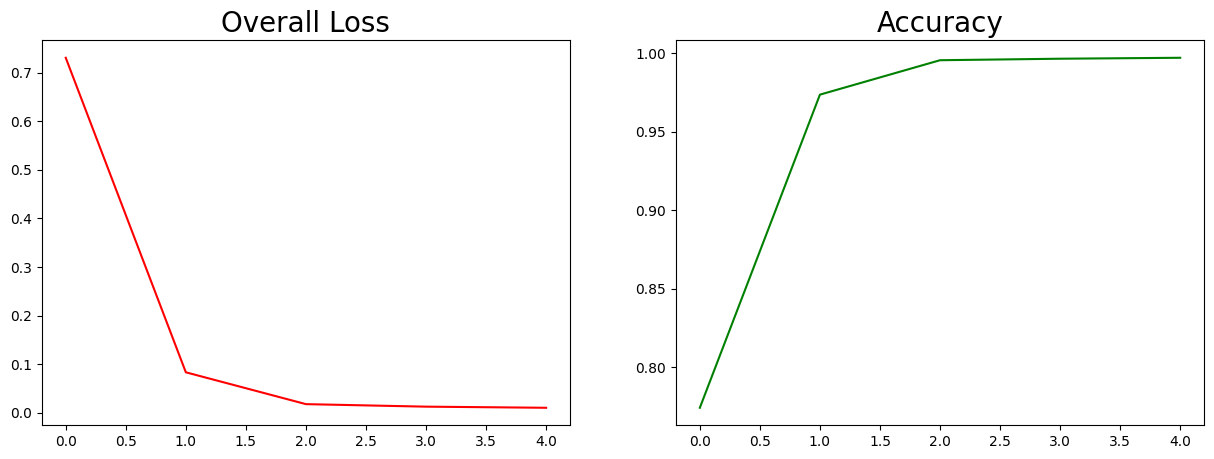

In [106]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Overall Loss',fontsize=20)
plt.plot(hist_['loss'],c='r',label='Overall Loss')
plt.subplot(1,2,2)
plt.title('Accuracy',fontsize=20)
plt.plot(hist_['accuracy'],c='g',label='Accuracy')

In [107]:
prediction=model.predict(X_test)

66/66 [==============================] - 2s 22ms/step


In [117]:
y_pred = np.argmax(prediction, axis=1)
pred = [get_code(y) for y in y_pred]

pd.DataFrame(pred, columns=['Predictions'])

,Predictions
0,Kannada
1,Arabic
2,Italian
3,Italian
4,Kannada
...,...
2083,Kannada
2084,Russian
2085,Russian
2086,Tamil


In [118]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       286
           1       1.00      0.98      0.99       122
           2       1.00      1.00      1.00        18
           3       0.98      1.00      0.99        94
           4       0.98      0.93      0.95       137
           5       0.98      0.99      0.98       203
           6       0.98      0.92      0.95       103
           7       0.97      0.96      0.97       175
           8       1.00      0.93      0.96        71
           9       1.00      0.92      0.96       143
          10       0.96      0.95      0.96        82
          11       1.00      0.96      0.98       138
          12       0.99      0.93      0.96        87
          13       1.00      0.94      0.97       140
          14       0.99      0.95      0.97       110
          15       0.97      0.97      0.97        89
          16       0.62      1.00      0.77        7

In [110]:
def prediction_func(sentence):
    sent=clean_text(sentence)
    sent=tfidf_vectorizer.transform([sent])
    sent=pd.DataFrame.sparse.from_spmatrix(sent)
    return get_code(np.argmax(model.predict(sent)))

In [111]:
#Arabic
text = "مرحبا كيف حالك؟"
prediction_func(text)

1/1 [==============================] - 0s 86ms/step


'Arabic'

In [112]:
#Bengali
prediction_func('শুধু জানাইতে আসলাম, আমার পাশে বসা এই ভদ্রলোককে দেখতে যতটা নিরীহ লাগতেছে, আসলে সে তা না!')

1/1 [==============================] - 0s 28ms/step


'Bengali'

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/language_detection.h5')